In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import itertools as it

In [13]:
#TYPE!!! Link to file.
link_to_file=r'C:\Users\VL\Desktop\Input_Data_for_production_forecast_calculation.xlsx'

ml_case=pd.read_excel(link_to_file, sheet_name='Wells_production_prognosis', parse_dates=['Date'])
gas_cap=pd.read_excel(link_to_file, sheet_name='Surf_Equip_gas_capacity', parse_dates=['Date'])

In [14]:
# Dictionary with gas capcity vs time
gas_capacity=dict(zip(gas_cap['Date'],gas_cap['Gas capacity, Mcfd']))

In [15]:
# ML case assumptions for each well
ml_case

,Well name,Type,Date,"Oil, kbd","Gas, Mcfd","GOR, Mcf/kb"
0,Well_1,Single producer,2022-12-15,0.964485,10.875000,4.904821
1,Well_1,Single producer,2023-01-15,0.940373,10.875000,5.030586
2,Well_1,Single producer,2023-02-15,0.916863,10.875000,5.159575
3,Well_1,Single producer,2023-03-15,0.893942,10.875000,5.291872
4,Well_1,Single producer,2023-04-15,0.871593,10.875000,5.427561
...,...,...,...,...,...,...
291,Well_8,Single producer,2025-08-15,0.629808,15.089743,11.979633
292,Well_8,Single producer,2025-09-15,0.626659,15.391538,12.280629
293,Well_8,Single producer,2025-10-15,0.623526,15.699369,12.589187
294,Well_8,Single producer,2025-11-15,0.620408,16.013356,12.905498


In [16]:
# Dictionary with min affordable choke for each well
choke_parameters=pd.read_excel(link_to_file, sheet_name='Choke_parameters')
choke_parameters=dict(zip(choke_parameters['Well name'], choke_parameters['Choke, fraction']))

print('Well name'.ljust(10), 'Choke, fraction', '\n', sep = "  ")
for i in choke_parameters:
    print(i.ljust(10), choke_parameters[i], sep = "- ")


Well name   Choke, fraction  

Well_1    - 0.1
Well_2    - 0.2
Well_3    - 0.15
Well_4    - 0.2
Well_5    - 0.15
Well_6    - 0.2
Well_7    - 0.3
Well_8    - 0.2


In [17]:
#Each item in lists below keeps value for given timeframe (one value for one timeframe following dates sequence)
max_gas_res=[]  #Factor limiting total production
marginal_GOR_res=[]
max_oil_res=[]
marginal_well=[]

df=ml_case.copy()

# Create a DataFrame with dates and wellnames filled with zeros
all_wells=pd.DataFrame(index=df['Date'].unique(),columns=df['Well name'].unique()).fillna(0)



for date in df['Date'].unique():

    # This part of code creates wellseriatum for each timeframe sorted by GOR
    temp_pivot=pd.pivot_table(df[df['Date']==date], index='Well name', values=['Oil, kbd','Gas, Mcfd','GOR, Mcf/kb']).sort_values(by='GOR, Mcf/kb')
    temp_pivot['Cum_gas']=temp_pivot['Gas, Mcfd'].cumsum()
    temp_pivot['Cum_oil']=temp_pivot['Oil, kbd'].cumsum()
    
    
    max_gas_capacity_of_surface_equipment=gas_capacity[pd.Timestamp(np.datetime64(date))]
    #Case when maximum gas capacity is excided
    total_gas_produced_by_all_wells = temp_pivot['Cum_gas'].max()
    if total_gas_produced_by_all_wells > max_gas_capacity_of_surface_equipment:
        
        gas_produced_at_min_chokes_by_all_wells, min_oil = 0, 0
        
        for well in choke_parameters:
            # Allocate min oil production at min choke levels to wells
            all_wells.loc[date, well] = temp_pivot.loc[well,'Oil, kbd'] * choke_parameters[well]
            
            # Calculate gas at min choke production levels
            gas_produced_at_min_chokes_by_all_wells += temp_pivot.loc[well,'Gas, Mcfd'] * choke_parameters[well]
            
            # Caclculate cummulative oil prodiction at min choke levels
            min_oil += temp_pivot.loc[well,'Oil, kbd'] * choke_parameters[well]
            
            # Reduce temp_pivot oil and gas production levels by values already written into output table
            temp_pivot.loc[well,'Oil, kbd'] = temp_pivot.loc[well,'Oil, kbd'] * (1 - choke_parameters[well])
            temp_pivot.loc[well,'Gas, Mcfd'] = temp_pivot.loc[well,'Gas, Mcfd'] * (1 - choke_parameters[well])
        
        #Recalculate cummulative gas and oil production
        temp_pivot['Cum_gas']=temp_pivot['Gas, Mcfd'].cumsum()
        temp_pivot['Cum_oil']=temp_pivot['Oil, kbd'].cumsum()
        max_gas_capacity_of_surface_equipment = max_gas_capacity_of_surface_equipment - gas_produced_at_min_chokes_by_all_wells
        fully_open_wells=temp_pivot[temp_pivot['Cum_gas']<=max_gas_capacity_of_surface_equipment]
        
        # Wells with cum Gas production below max gas capacity are added to output
        for x in temp_pivot[temp_pivot['Cum_gas']<=max_gas_capacity_of_surface_equipment].index:
            all_wells.loc[date,x]= all_wells.loc[date,x]+temp_pivot.loc[x,'Oil, kbd']
            
        
        gas_from_fully_open_wells=temp_pivot[temp_pivot['Cum_gas']<=max_gas_capacity_of_surface_equipment].iloc[-1]['Cum_gas']
        choked_wells=temp_pivot[temp_pivot['Cum_gas']>max_gas_capacity_of_surface_equipment].iloc[0]
        all_wells.loc[date,choked_wells.name]=all_wells.loc[date,choked_wells.name] + (max_gas_capacity_of_surface_equipment-gas_from_fully_open_wells)/choked_wells['GOR, Mcf/kb']
        
        oil=temp_pivot[temp_pivot['Cum_gas']<=max_gas_capacity_of_surface_equipment].iloc[-1]['Cum_oil']
        gas=temp_pivot[temp_pivot['Cum_gas']<=max_gas_capacity_of_surface_equipment].iloc[-1]['Cum_gas']
        marginal_GOR=temp_pivot[temp_pivot['Cum_gas']>max_gas_capacity_of_surface_equipment].iloc[0]['GOR, Mcf/kb']
        max_oil=oil+(max_gas_capacity_of_surface_equipment-gas)/marginal_GOR
        marginal_well.append(temp_pivot[temp_pivot['Cum_gas']>max_gas_capacity_of_surface_equipment].iloc[0].name)
    
    #Case when max gas capacity is not excided
    else:
        for x in temp_pivot.index:
            all_wells.loc[date,x]=temp_pivot.loc[x,'Oil, kbd']
        max_oil=temp_pivot['Cum_oil'].max()
        max_gas_capacity_of_surface_equipment=temp_pivot['Cum_gas'].max()
        marginal_GOR=temp_pivot.iloc[-1]['Gas, Mcfd']/temp_pivot.iloc[-1]['Oil, kbd']
        marginal_well.append(temp_pivot.iloc[-1].name)
        

    max_gas_res.append(max_gas_capacity_of_surface_equipment+gas_produced_at_min_chokes_by_all_wells)
    marginal_GOR_res.append(marginal_GOR)
    max_oil_res.append(max_oil + min_oil)
    
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

output_df=pd.DataFrame(data={'Date':df['Date'].unique(), 'Oil, kbd':max_oil_res, 'Gas, Mcfd':max_gas_res, 
                                 'Well with marginal GOR':marginal_well, 'GOR of Marginal Well':marginal_GOR_res}).copy()
display(output_df,all_wells)    



,Date,"Oil, kbd","Gas, Mcfd",Well with marginal GOR,GOR of Marginal Well
0,2022-12-15,22.404341,117.59580,Well_8,5.414727
1,2023-01-15,21.923816,117.11385,Well_8,5.550776
2,2023-02-15,21.286433,115.66800,Well_8,5.690243
3,2023-03-15,20.669536,114.22215,Well_8,5.833213
4,2023-04-15,20.998814,112.29435,Well_1,5.427561
5,2023-05-15,20.195127,109.88460,Well_1,5.566729
6,2023-06-15,19.421015,107.47485,Well_1,5.709466
7,2023-07-15,18.922377,106.51095,Well_1,5.855863
8,2023-08-15,18.679721,106.99290,Well_1,6.006013
9,2023-09-15,18.596272,108.43875,Well_1,6.160013


,Well_1,Well_2,Well_3,Well_4,Well_5,Well_6,Well_7,Well_8
2022-12-15,0.964485,7.234365,5.425774,4.569401,1.507431,0.221721,1.231781,1.249384
2023-01-15,0.940373,7.129467,5.347100,4.523707,1.492357,0.216178,1.200987,1.073649
2023-02-15,0.916863,7.026089,5.269567,4.478470,1.477433,0.210773,1.170962,0.736275
2023-03-15,0.893942,6.924211,5.193158,4.433685,1.462659,0.205504,1.141688,0.414689
2023-04-15,1.761313,6.823810,5.117858,4.389348,1.448032,0.200366,1.113146,0.144941
2023-05-15,1.222716,6.724865,5.043649,4.345455,1.433552,0.195357,1.085317,0.144217
2023-06-15,0.709775,6.627354,4.970516,4.302000,1.419217,0.190473,1.058184,0.143495
2023-07-15,0.468453,6.531258,4.898443,4.258980,1.405024,0.185711,1.031730,0.142778
2023-08-15,0.479318,6.436554,4.827416,4.216390,1.390974,0.181069,1.005936,0.142064
2023-09-15,0.645655,6.343224,4.757418,4.174226,1.377064,0.176542,0.980788,0.141354


<AxesSubplot:>

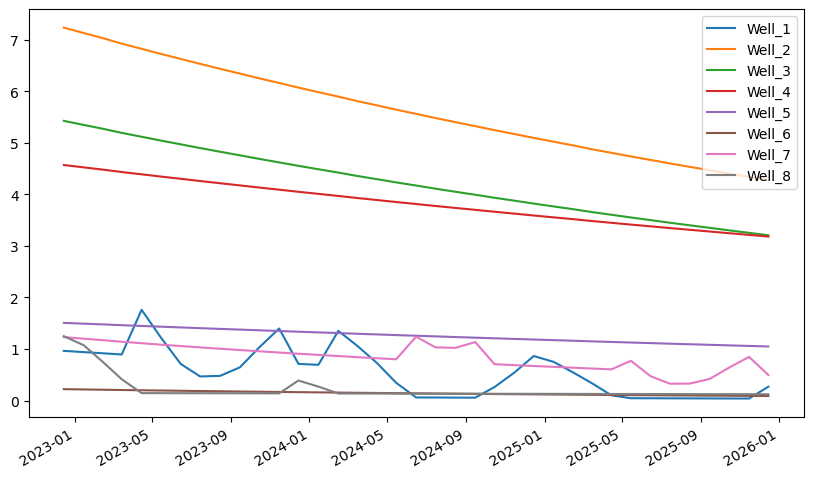

In [18]:
all_wells.plot(figsize=(10,6))